In [1]:
from orange_peels import OrangePeelsDataset
from orange_peels import Constants as c
import utils
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os

$$\text{train on split}\rightarrow\text{test on original}$$

In [2]:
transform = transforms.Compose([
    transforms.Normalize(mean=c.RESNET_MEAN, std=c.RESNET_STD)
])

inv_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.,], std = [1/sd for sd in c.RESNET_STD]),
    transforms.Normalize(mean = [-m for m in c.RESNET_MEAN], std = [1., 1., 1.]),
])

In [3]:
model_name = "resnet50"
device = utils.get_device()
base = torch.hub.load("pytorch/vision:v0.13.1", model_name, weights="ResNet50_Weights.DEFAULT")

Device: cuda:0


Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.13.1


In [4]:
data_split = OrangePeelsDataset("./data_orange_peels_split/", class_size=2063, transform=transform, stats=True)

Class: 10	Available: 2571		Added: 2063
Class: 15	Available: 2690		Added: 2063
Class: 20	Available: 2755		Added: 2063
Class: 6	Available: 2063		Added: 2063
		Total: 10079		Total: 8252


In [5]:
data_original = OrangePeelsDataset(c.IMG_DIR, class_size=91, transform=transform, stats=True)

Class: 10	Available: 142		Added: 91
Class: 15	Available: 98		Added: 91
Class: 20	Available: 116		Added: 91
Class: 6	Available: 91		Added: 91
		Total: 447		Total: 364


This took $>3200$ minutes. Stopped at $3$ to $4$ epochs.

In [ ]:
train_split_loader, test_split_loader = utils.create_loader(data_split, prop=0.8)
_, test_original_loader = utils.create_loader(data_original, prop=0.8)
optimizer = torch.optim.Adam
criterion = nn.CrossEntropyLoss()
model, optimizer = utils.create_model(base, optimizer, output_layers=2048, remove_layers=1, device=device)
train_split_loss, train_split_acc, test_split_acc, test_original_acc = utils.train_split_model(
    model, train_split_loader, test_split_loader, test_original_loader, optimizer, criterion, device=device, stats=True
)

In [16]:
# read results.txt line by line
train_split_loss = []
train_split_acc = []
test_split_acc = []
test_original_acc = []
with open("results.txt", "r") as f:
    for line in f:
        if line.startswith("\t[B"):
            l = line.split(',')
            train_split_loss.append(float(l[0][l[0].find("Loss")+5:]))
            train_split_acc.append(float(l[1][l[1].find("Train")+6:]))
            test_split_acc.append(float(l[2][l[2].find("Test")+5:]))
            test_original_acc.append(float(l[3][l[3].find("Original")+9:]))


In [64]:
pred_split, true_split = utils.test_model(model, test_split_loader, device=device, save=True)

In [62]:
pred_original, true_original = utils.test_split_model(model, test_original_loader, device=device, save=True)

In [63]:
utils.results_to_json(f"{model_name}_split.json", train_split_loss, train_split_acc, test_original_acc, pred_original, true_original)

In [66]:
print("Accuracy Original:", (pred_original == true_original).sum() / len(pred_original))
print("Accuracy Split:", (pred_split == true_split).sum() / len(pred_split))

Accuracy Original: 0.3835616438356164
Accuracy Split: 0.6414294367050273


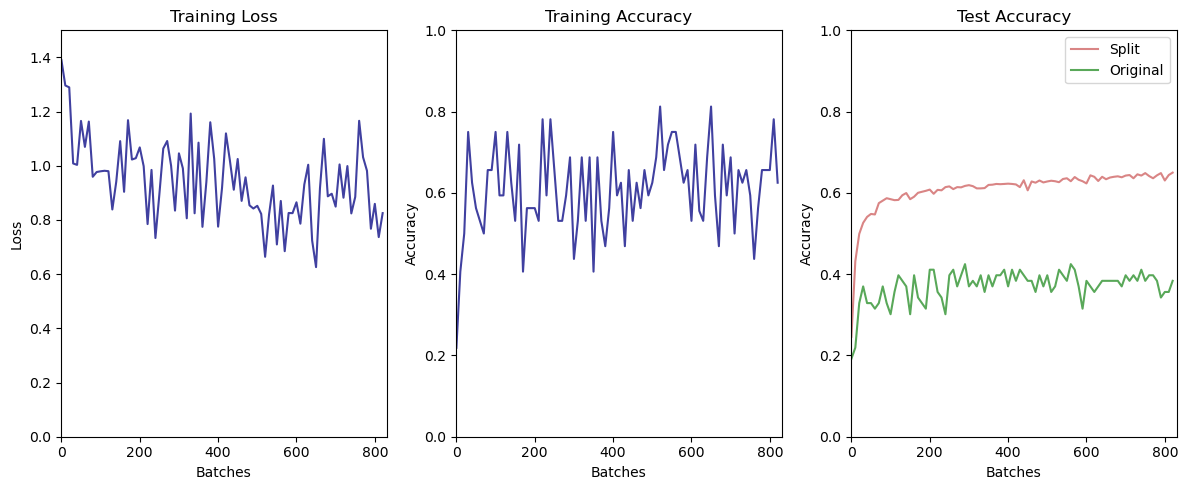

In [67]:
n=10

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes[0].plot(train_split_loss[0::n], color="navy", alpha=0.75)
axes[0].set_title("Training Loss")
axes[0].set_ylim([0, 1.5])

axes[1].plot(train_split_acc[0::n], color="navy", alpha=0.75)
axes[1].set_title("Training Accuracy")
axes[1].set_ylim([0, 1])

axes[2].plot(test_split_acc[0::n], color="indianred", alpha=0.75)
axes[2].plot(test_original_acc[0::n], color="forestgreen", alpha=0.75)
axes[2].set_title("Test Accuracy")
axes[2].legend(["Split", "Original"])
axes[2].set_ylim([0, 1])

for i in range(3):
    axes[i].set_xlabel("Batches")
    axes[i].set_ylabel("Accuracy" if i > 0 else "Loss")
    axes[i].set_xticks(
        range(0, len(train_split_loss[0::n]), 2*n),
        labels=range(0, 10*len(train_split_loss[0::n]), 2*10*n)
    )
    axes[i].set_xlim([0, len(train_split_loss[0::n])])

fig.tight_layout()
plt.show()

In [70]:
import json

c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2bb5abe8a60>,
 {'0': {'precision': 1.0,
   'recall': 0.05555555555555555,
   'f1-score': 0.10526315789473684,
   'support': 18},
  '1': {'precision': 0.4074074074074074,
   'recall': 0.4583333333333333,
   'f1-score': 0.4313725490196078,
   'support': 24},
  '2': {'precision': 0.35555555555555557,
   'recall': 0.9411764705882353,
   'f1-score': 0.5161290322580645,
   'support': 17},
  '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14},
  'accuracy': 0.3835616438356164,
  'macro avg': {'precision': 0.44074074074074077,
   'recall': 0.36376633986928103,
   'f1-score': 0.2631911847931023,
   'support': 73},
  'weighted avg': {'precision': 0.4633181126331811,
   'recall': 0.3835616438356164,
   'f1-score': 0.28797084338305406,
   'support': 73}})

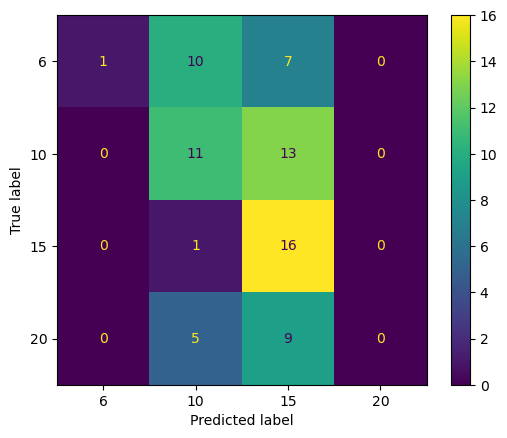

In [79]:
utils.generate_metrics(true_original, pred_original)

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2bb5a1170d0>,
 {'0': {'precision': 0.7813267813267813,
   'recall': 0.724373576309795,
   'f1-score': 0.75177304964539,
   'support': 439},
  '1': {'precision': 0.543026706231454,
   'recall': 0.4552238805970149,
   'f1-score': 0.49526387009472256,
   'support': 402},
  '2': {'precision': 0.6426426426426426,
   'recall': 0.5206812652068127,
   'f1-score': 0.575268817204301,
   'support': 411},
  '3': {'precision': 0.5993031358885017,
   'recall': 0.8621553884711779,
   'f1-score': 0.7070914696813977,
   'support': 399},
  'accuracy': 0.6414294367050273,
  'macro avg': {'precision': 0.6415748165223449,
   'recall': 0.6406085276462001,
   'f1-score': 0.6323493016564528,
   'support': 1651},
  'weighted avg': {'precision': 0.6447893823459356,
   'recall': 0.6414294367050273,
   'f1-score': 0.6345786946373411,
   'support': 1651}})

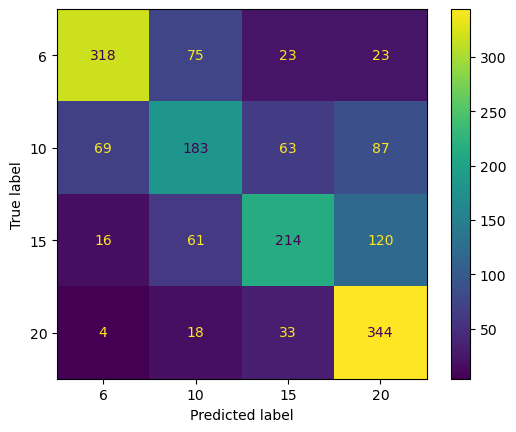

In [69]:
utils.generate_metrics(true_split, pred_split)

{
    "0": {
        "precision": 1.0,
        "recall": 0.05555555555555555,
        "f1-score": 0.10526315789473684,
        "support": 18
    },
    "1": {
        "precision": 0.4074074074074074,
        "recall": 0.4583333333333333,
        "f1-score": 0.4313725490196078,
        "support": 24
    },
    "2": {
        "precision": 0.35555555555555557,
        "recall": 0.9411764705882353,
        "f1-score": 0.5161290322580645,
        "support": 17
    },
    "3": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 14
    },
    "accuracy": 0.3835616438356164,
    "macro avg": {
        "precision": 0.44074074074074077,
        "recall": 0.36376633986928103,
        "f1-score": 0.2631911847931023,
        "support": 73
    },
    "weighted avg": {
        "precision": 0.4633181126331811,
        "recall": 0.3835616438356164,
        "f1-score": 0.28797084338305406,
        "support": 73
    }
}


c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


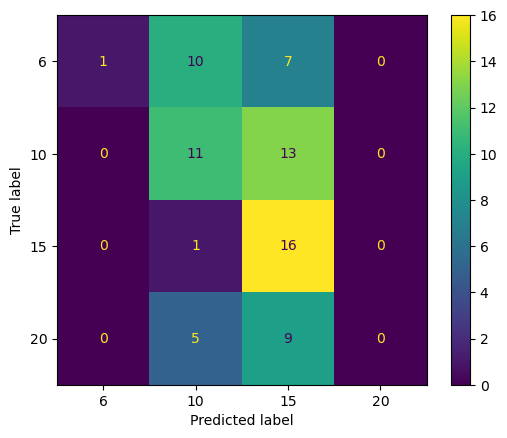

In [81]:
metrics = utils.generate_metrics(true_original, pred_original)[1]
print(json.dumps(metrics, indent=4))